## Capstone Project 1

### Data preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

data = pd.read_csv("ford_car_price_prediction.csv")
data.head(10)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0
5,Fiesta,2015,10500,Manual,35432,Petrol,145,47.9,1.6
6,Puma,2019,22500,Manual,2029,Petrol,145,50.4,1.0
7,Fiesta,2017,9000,Manual,13054,Petrol,145,54.3,1.2
8,Kuga,2019,25500,Automatic,6894,Diesel,145,42.2,2.0
9,Focus,2018,10000,Manual,48141,Petrol,145,61.4,1.0


In [2]:
data.describe()

,year,price,mileage,tax,mpg,engineSize
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,2016.993836,12280.198630,21907.027397,108.205479,58.609726,1.361438
std,1.632212,4447.710936,15874.464065,62.334075,9.577440,0.436243
min,2013.000000,3691.000000,5.000000,0.000000,20.900000,1.000000
25%,2016.000000,9000.000000,10174.000000,30.000000,54.300000,1.000000
50%,2017.000000,11199.000000,17863.500000,145.000000,58.900000,1.200000
75%,2018.000000,14998.000000,29859.750000,145.000000,65.700000,1.500000
max,2020.000000,42489.000000,88927.000000,570.000000,88.300000,5.000000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1460 non-null   object 
 1   year          1460 non-null   int64  
 2   price         1460 non-null   int64  
 3   transmission  1460 non-null   object 
 4   mileage       1460 non-null   int64  
 5   fuelType      1460 non-null   object 
 6   tax           1460 non-null   int64  
 7   mpg           1460 non-null   float64
 8   engineSize    1460 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 102.8+ KB


In [4]:
data.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [5]:
print("Dataset dimensions:", data.shape)

Dataset dimensions: (1460, 9)


In [6]:
target_label = 'price'
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fueltype', 'tax',
       'mpg', 'enginesize'],
      dtype='object')

In [7]:
categorical_cols = ['model', 'transmission', 'fueltype']
numerical_cols = ['year', 'mileage', 'tax', 'mpg', 'enginesize']
y = data[[target_label]]

### 2. Exploratory Data Analysis (EDA)

### 2.1 Dataset dimensions

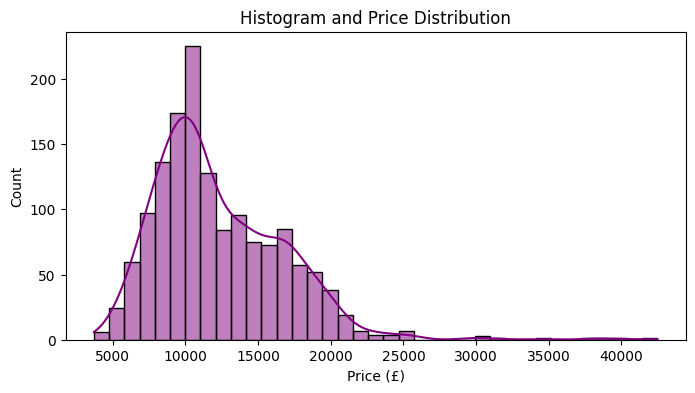

In [12]:
plt.figure(figsize=(8,4))
sns.histplot(data['price'], kde=True, color='purple')
plt.title("Histogram and Price Distribution")
plt.xlabel("Price (£)")
plt.ylabel("Count")
plt.show()

In [ ]:
### 2.2 Univariate Analysis of Categorical Variables

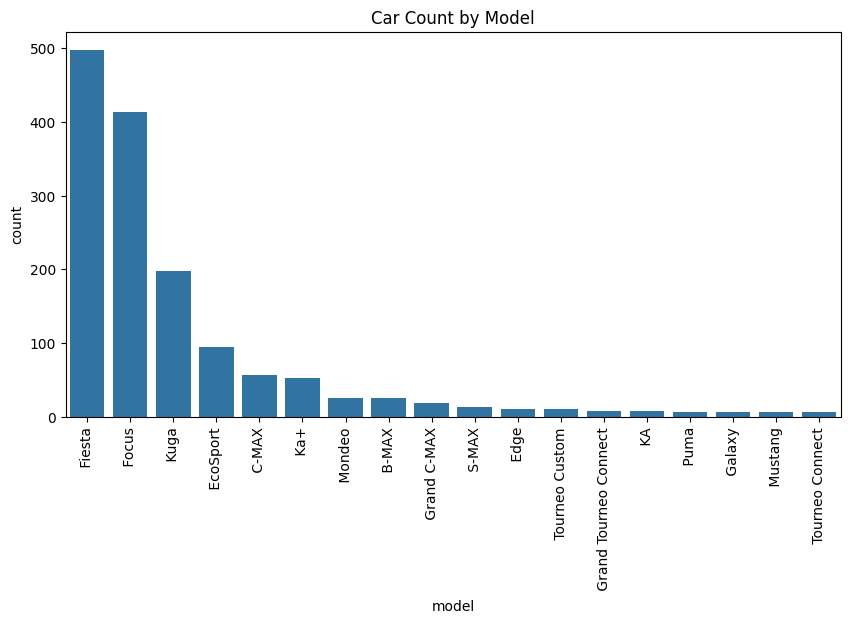

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(x='model', data=data, order=data['model'].value_counts().index)
plt.title("Car Count by Model")
plt.xticks(rotation=90)
plt.show()

### 2.3 Univariate Analysis of Numerical Variables

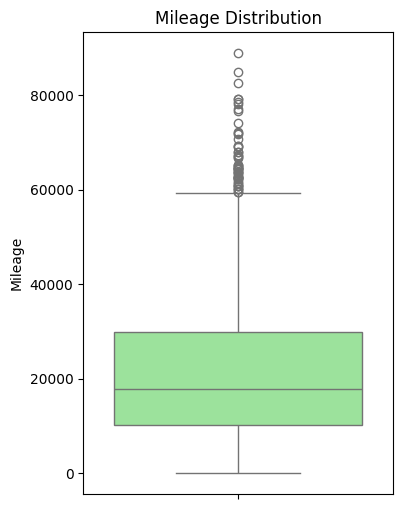

In [14]:
plt.figure(figsize=(4,6))
sns.boxplot(y='mileage', data=data, color='lightgreen')
plt.title("Mileage Distribution")
plt.ylabel("Mileage")
plt.show()

### 2.4 Categorical vs Target Relationship

/tmp/ipykernel_692/1250747153.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='fueltype', y='price', data=data, palette='pastel')


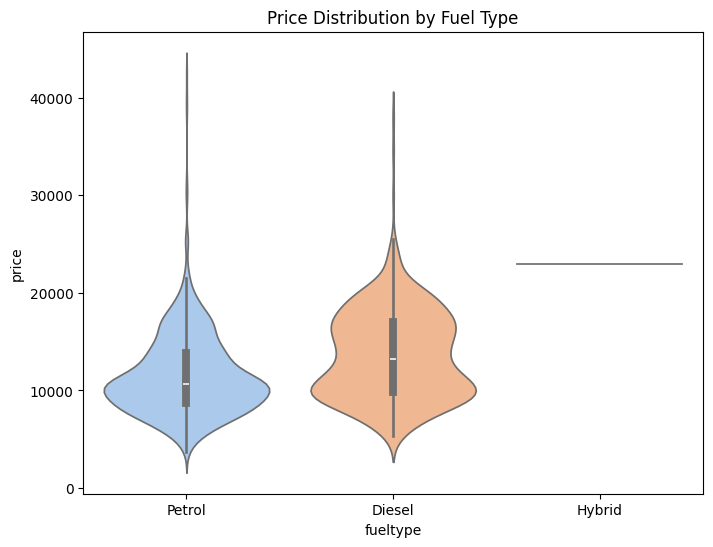

In [18]:
plt.figure(figsize=(8,6))
sns.violinplot(x='fueltype', y='price', data=data, palette='pastel')
plt.title("Price Distribution by Fuel Type")
plt.show()

### 2.5 Impacto de Categorias no Preço Médio

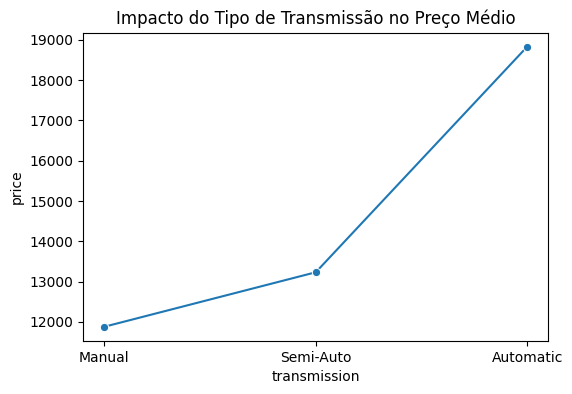

In [19]:
avg_price_trans = data.groupby('transmission')['price'].mean().reset_index().sort_values(by='price')
plt.figure(figsize=(6,4))
sns.lineplot(x='transmission', y='price', data=avg_price_trans, marker='o')
plt.title("Impact of Transmission Type on Average Price")
plt.show()

### 2.6 Relação Numérica vs Target (Scatterplot + Regressão)

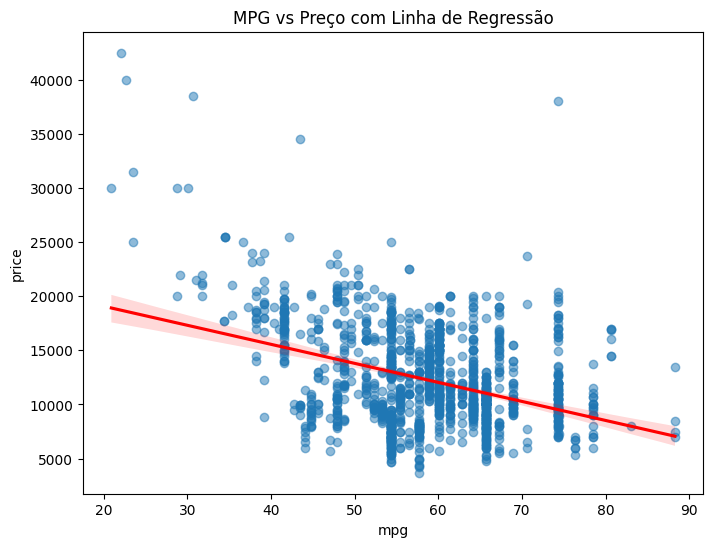

In [20]:
plt.figure(figsize=(8,6))
sns.regplot(x='mpg', y='price', data=data, scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
plt.title("MPG vs Preço com Linha de Regressão")
plt.show()

### 2.7 Jointplot (Relação Bivariada Detalhada)

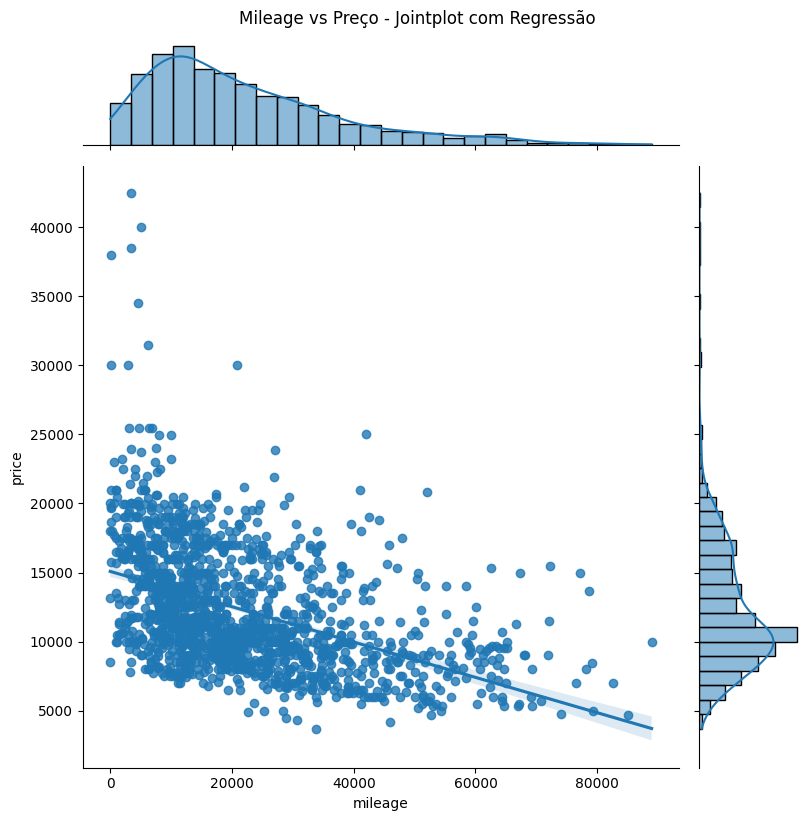

In [21]:
sns.jointplot(x='mileage', y='price', data=data, kind='reg', height=8)
plt.suptitle("Mileage vs Preço - Jointplot com Regressão", y=1.02)
plt.show()

### 2.8 Relação Categórica vs Categórica + Target (Heatmap)

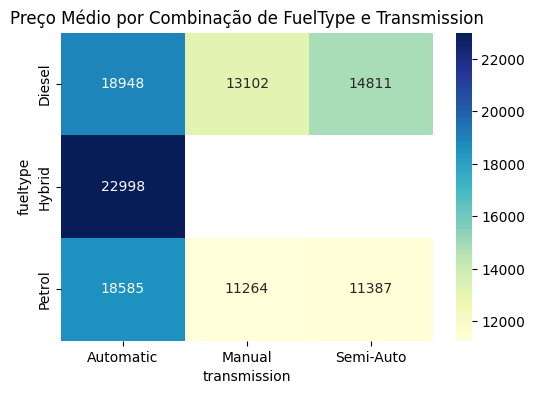

In [22]:
pivot_df = data.pivot_table(values='price', index='fueltype', columns='transmission', aggfunc='mean')
plt.figure(figsize=(6,4))
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt=".0f")
plt.title("Preço Médio por Combinação de FuelType e Transmission")
plt.show()

### 2.9 Análise Multivariada (Pairplot)

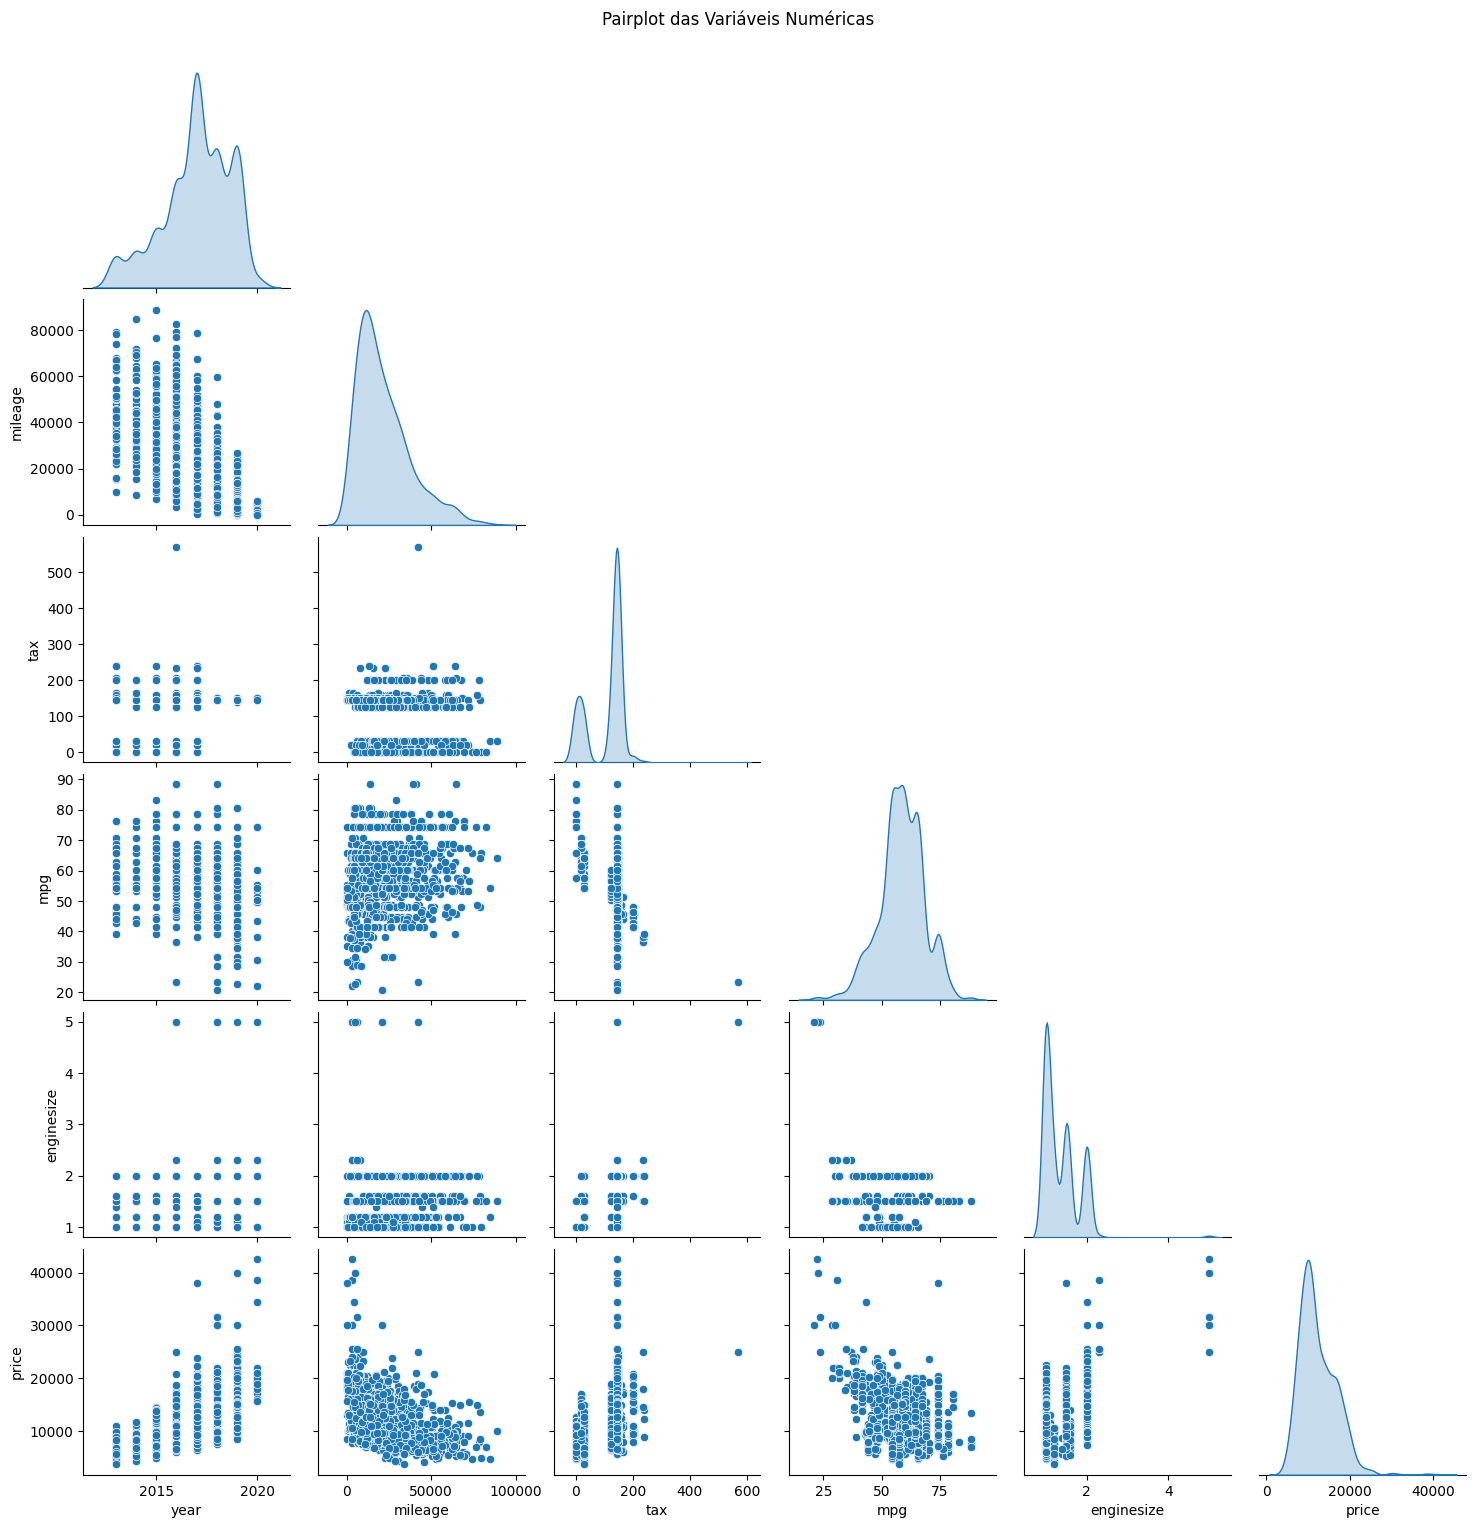

In [23]:
sns.pairplot(data, vars=['year','mileage','tax','mpg','enginesize','price'], diag_kind='kde', corner=True)
plt.suptitle("Pairplot das Variáveis Numéricas", y=1.02)
plt.show()

### 2.10 Correlações Avançadas (Clustermap)

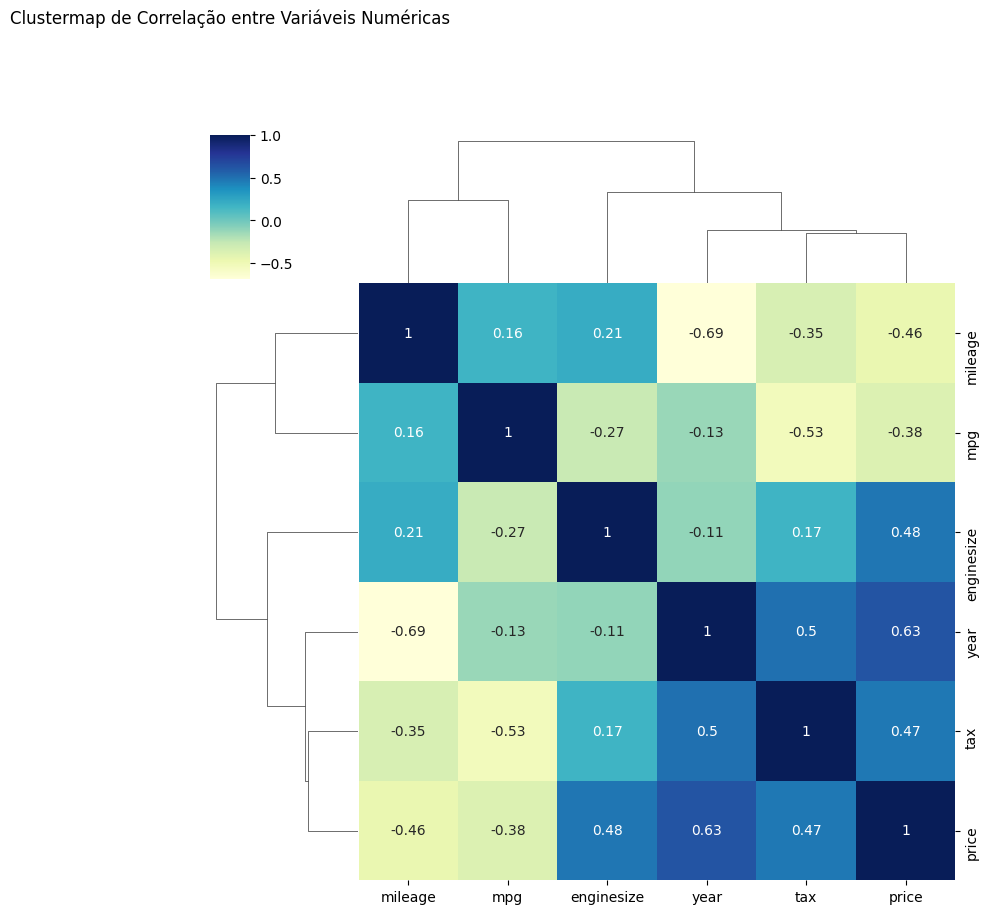

In [24]:
corr = data[['year','mileage','tax','mpg','enginesize','price']].corr()
sns.clustermap(corr, annot=True, cmap='YlGnBu', figsize=(8,8))
plt.title("Clustermap de Correlação entre Variáveis Numéricas", pad=80)
plt.show()

### 2.11 Segmentação (Binning) de Variáveis Numéricas

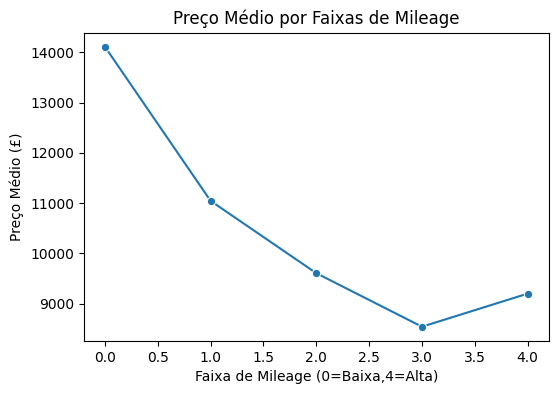

In [25]:
data['mileage_bin'] = pd.cut(data['mileage'], bins=5, labels=False)
avg_price_bins = data.groupby('mileage_bin')['price'].mean().reset_index()
plt.figure(figsize=(6,4))
sns.lineplot(x='mileage_bin', y='price', data=avg_price_bins, marker='o')
plt.title("Preço Médio por Faixas de Mileage")
plt.xlabel("Faixa de Mileage (0=Baixa,4=Alta)")
plt.ylabel("Preço Médio (£)")
plt.show()

### 2.12 Comparação de Distribuições em Subconjuntos (KDE)

/tmp/ipykernel_692/3431088964.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset['price'], label=ftype, shade=True)
/tmp/ipykernel_692/3431088964.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset['price'], label=ftype, shade=True)


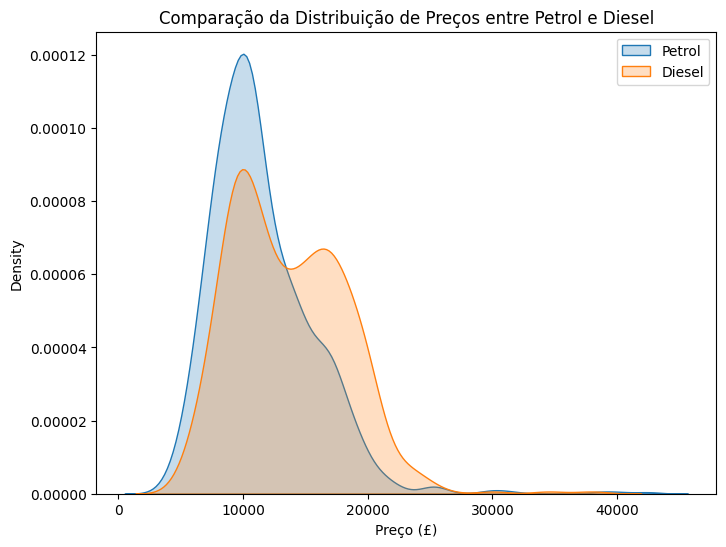

In [26]:
plt.figure(figsize=(8,6))
for ftype in ['Petrol','Diesel']:
    subset = data[data['fueltype'] == ftype]
    sns.kdeplot(subset['price'], label=ftype, shade=True)
plt.title("Comparação da Distribuição de Preços entre Petrol e Diesel")
plt.xlabel("Preço (£)")
plt.legend()
plt.show()

### 2.13. Visualização de Densidade 2D (Hexbin)

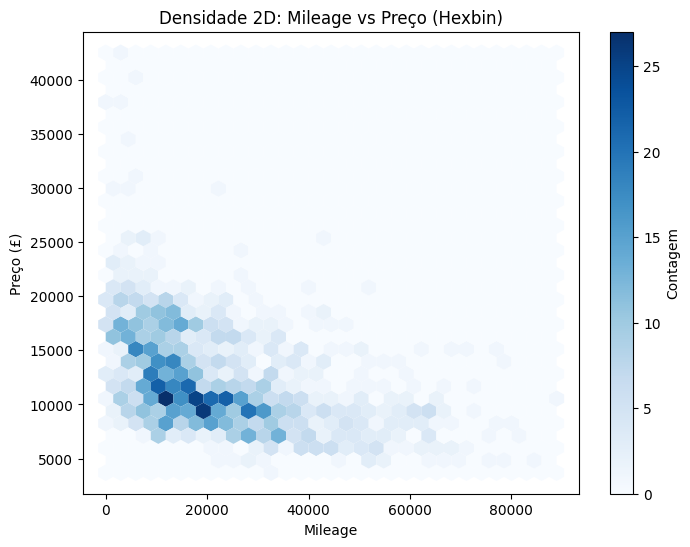

In [27]:
plt.figure(figsize=(8,6))
plt.hexbin(x=data['mileage'], y=data['price'], gridsize=30, cmap='Blues', edgecolors='none')
plt.colorbar(label='Contagem')
plt.xlabel("Mileage")
plt.ylabel("Preço (£)")
plt.title("Densidade 2D: Mileage vs Preço (Hexbin)")
plt.show()

### 2.14 PCA Biplot (Dimensionality Reduction Insight)

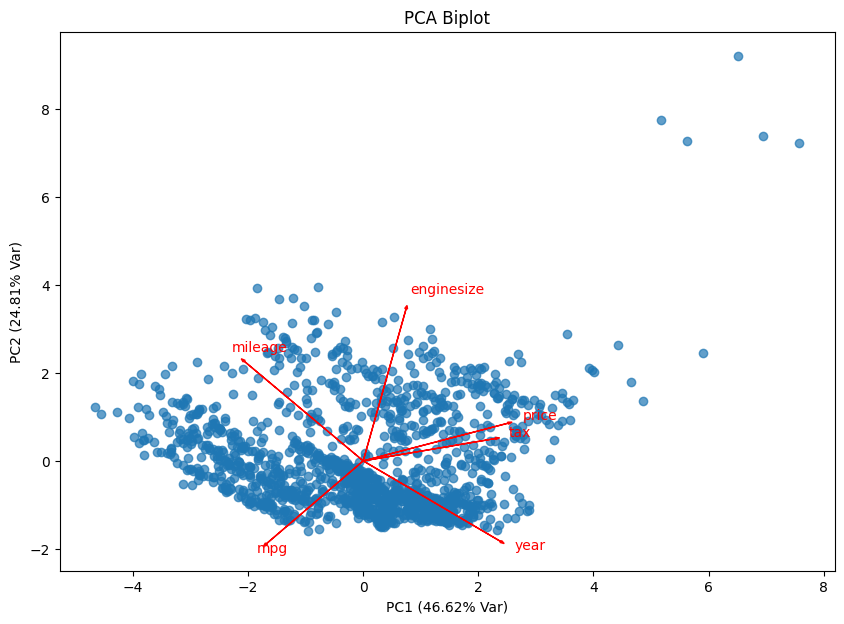

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

numeric_features = ['year','mileage','tax','mpg','enginesize','price']
X = data[numeric_features]

X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,7))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.7)
plt.title("PCA Biplot")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Var)")

loadings = pca.components_.T
for i, feat in enumerate(numeric_features):
    plt.arrow(0, 0, loadings[i,0]*5, loadings[i,1]*5, color='r', head_width=0.05)
    plt.text(loadings[i,0]*5*1.1, loadings[i,1]*5*1.1, feat, color='r')

plt.show()

### 2.15 Parallel Coordinates Plot (High-Dimensional Pattern Visualization)

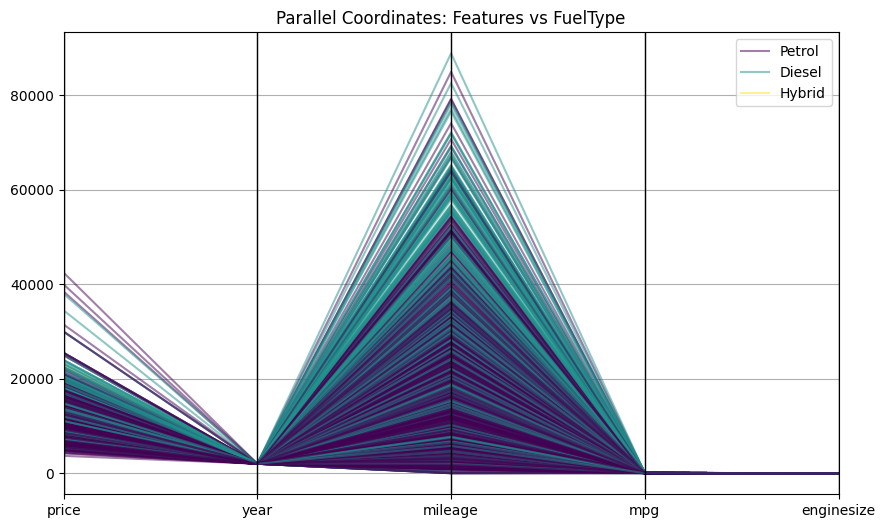

In [30]:
from pandas.plotting import parallel_coordinates

subset_cols = ['price','year','mileage','mpg','enginesize','fueltype']
parallel_df = data[subset_cols].dropna() # ensure no missing

plt.figure(figsize=(10,6))
parallel_coordinates(parallel_df, 'fueltype', colormap='viridis', alpha=0.5)
plt.title("Parallel Coordinates: Features vs FuelType")
plt.show()

### 2.16 Andrews Curves (Pattern Recognition in Multivariate Data)

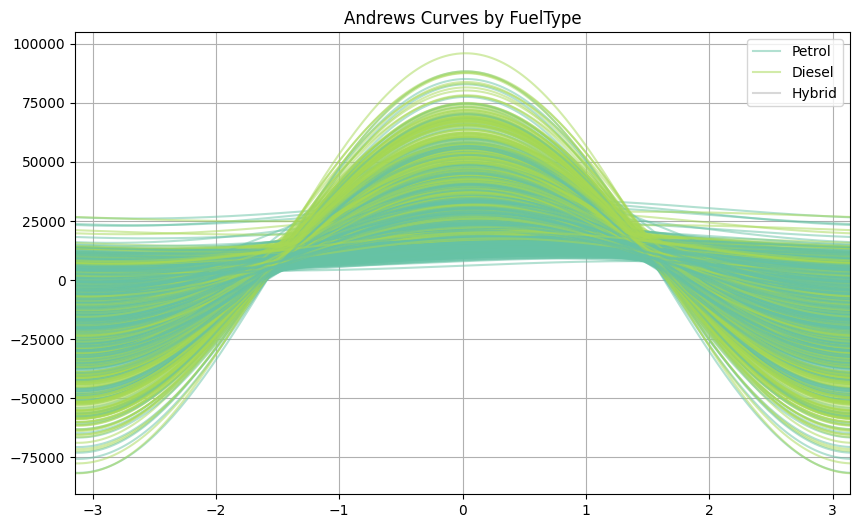

In [31]:
from pandas.plotting import andrews_curves

andrews_df = data[['price','year','mileage','mpg','enginesize','fueltype']].dropna()
plt.figure(figsize=(10,6))
andrews_curves(andrews_df, 'fueltype', colormap='Set2', alpha=0.5)
plt.title("Andrews Curves by FuelType")
plt.show()

### TEST

Unique Values and Counts of Categorical Variables:
model - Unique Values and Counts:
model
Fiesta                   497
Focus                    413
Kuga                     198
EcoSport                  94
C-MAX                     57
Ka+                       53
Mondeo                    26
B-MAX                     25
Grand C-MAX               19
S-MAX                     13
Edge                      11
Tourneo Custom            11
Grand Tourneo Connect      8
KA                         8
Puma                       7
Galaxy                     7
Mustang                    7
Tourneo Connect            6
Name: count, dtype: int64

transmission - Unique Values and Counts:
transmission
Manual       1313
Semi-Auto      78
Automatic      69
Name: count, dtype: int64

fueltype - Unique Values and Counts:
fueltype
Petrol    944
Diesel    515
Hybrid      1
Name: count, dtype: int64



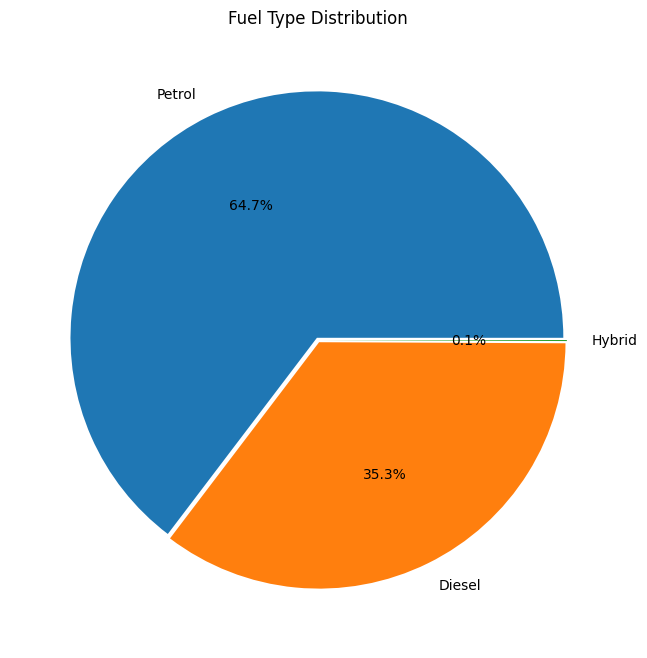

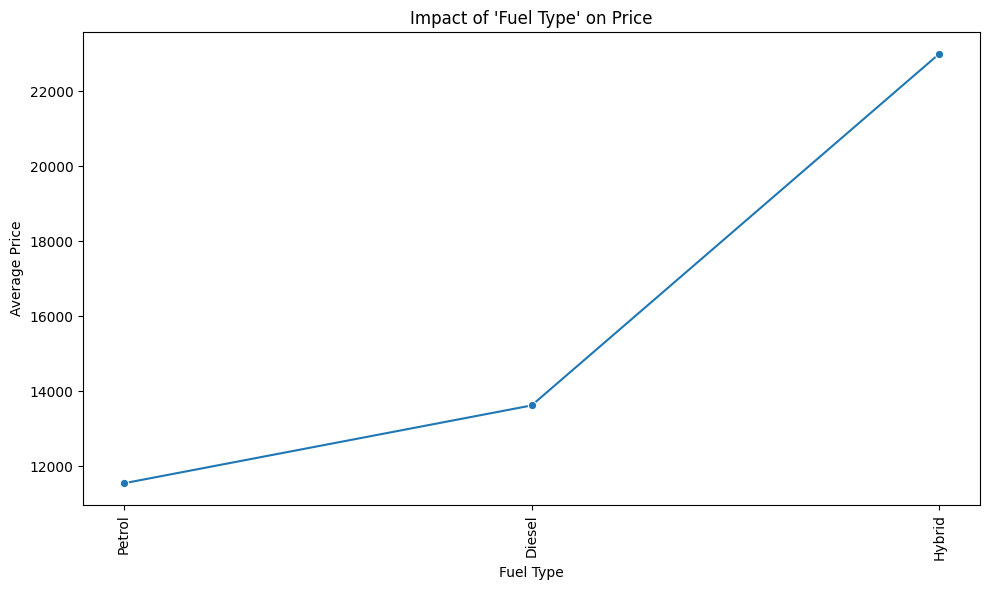

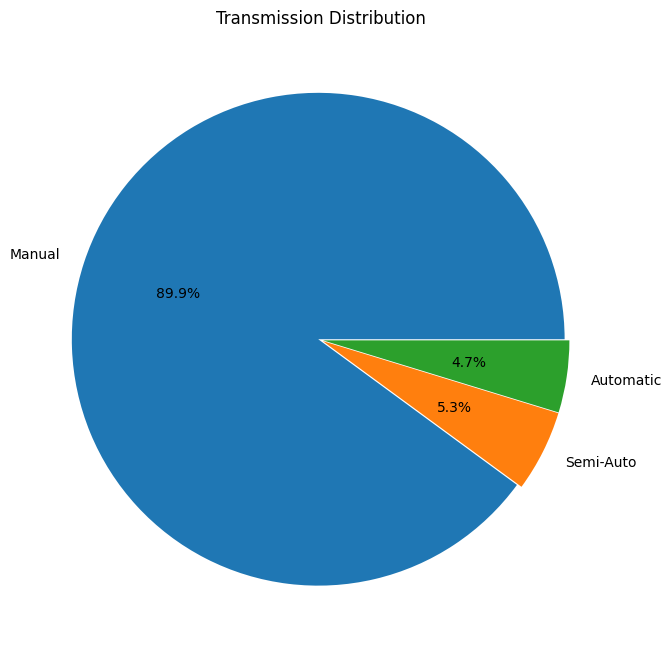

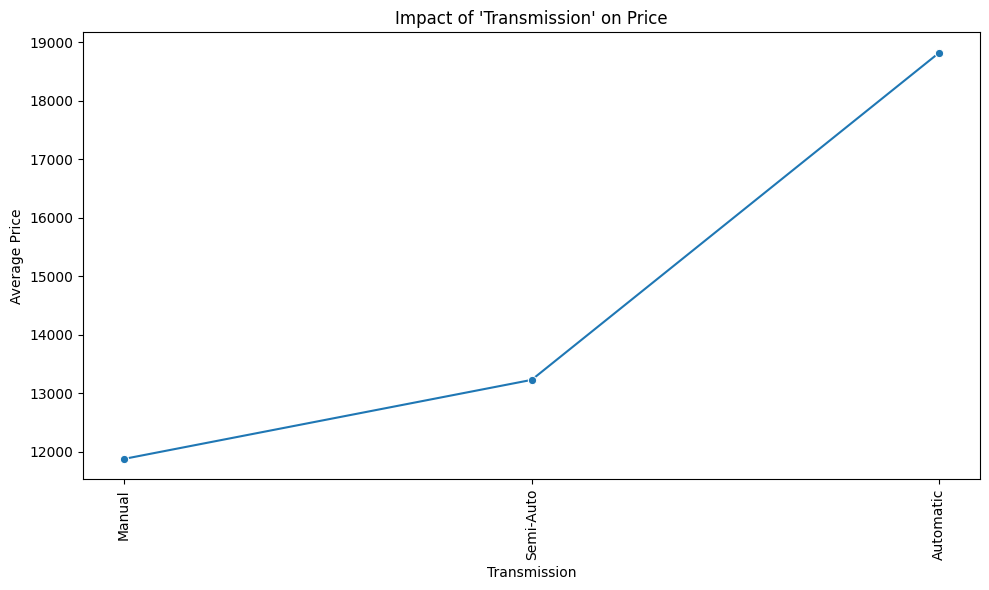

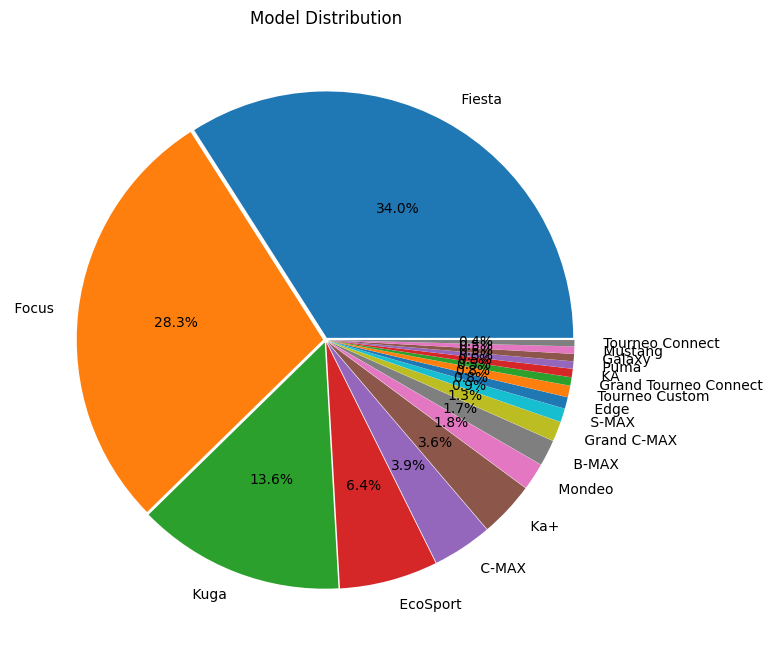

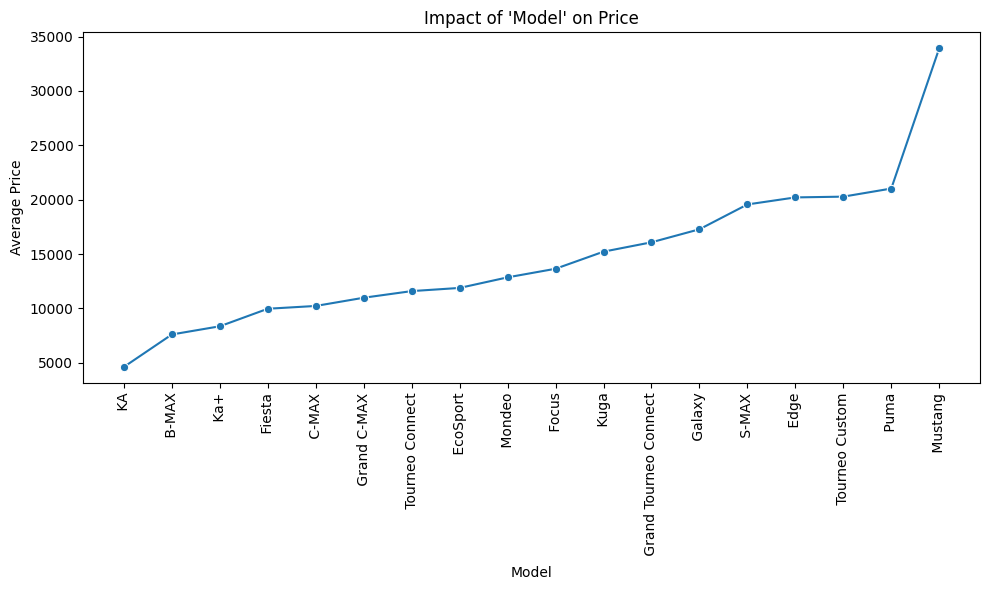

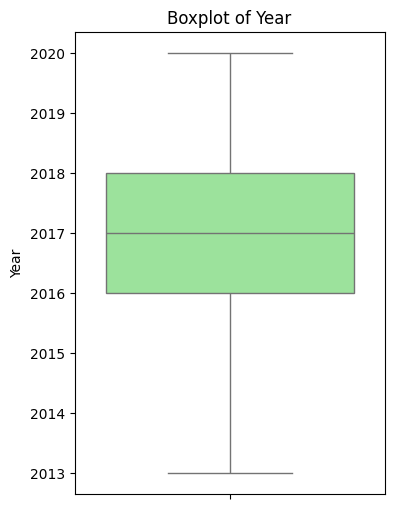

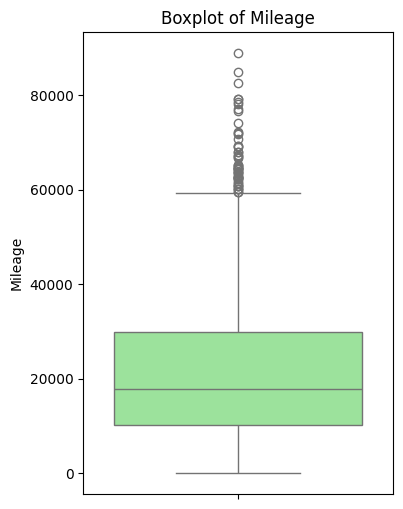

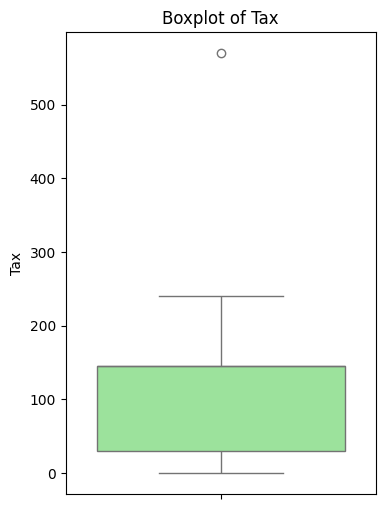

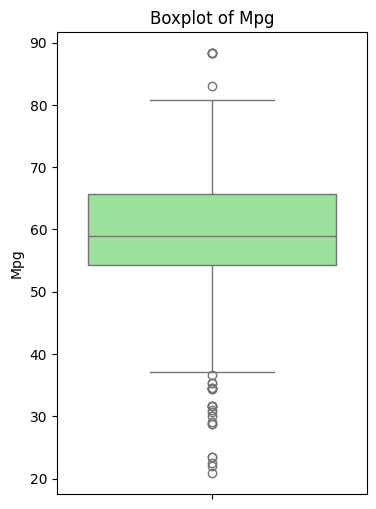

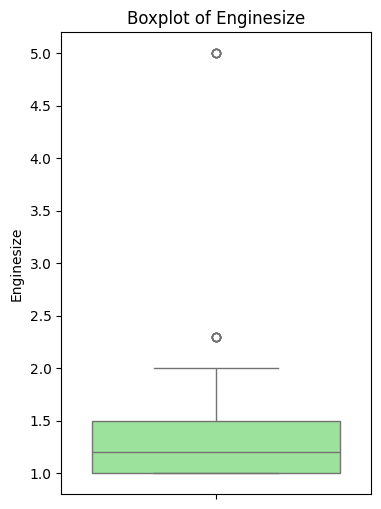

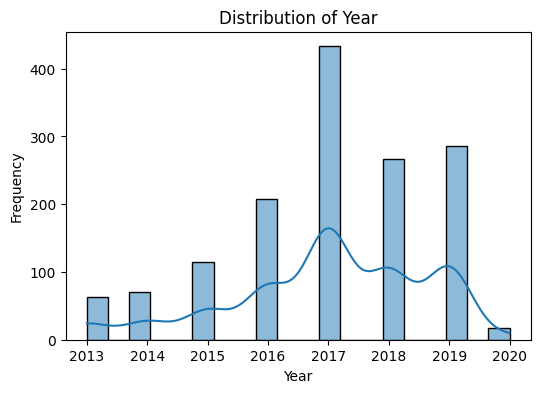

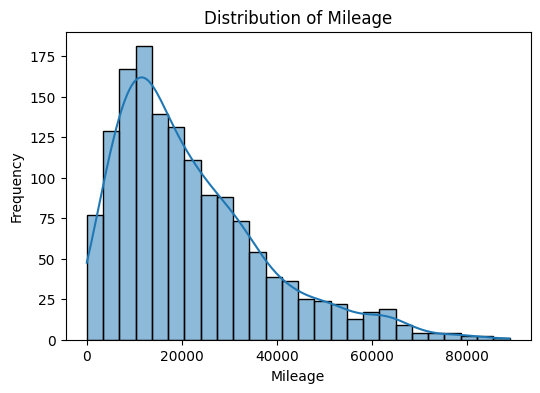

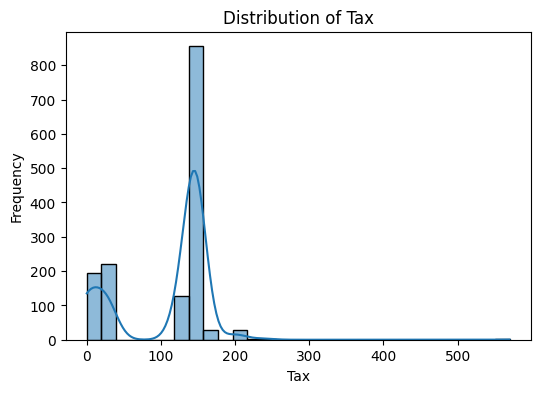

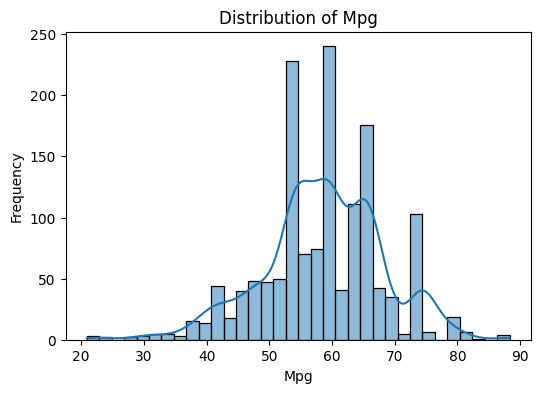

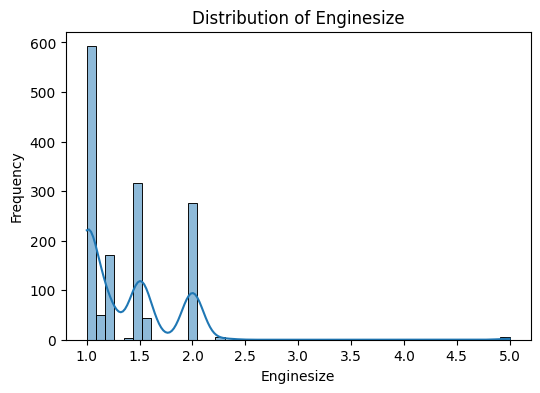

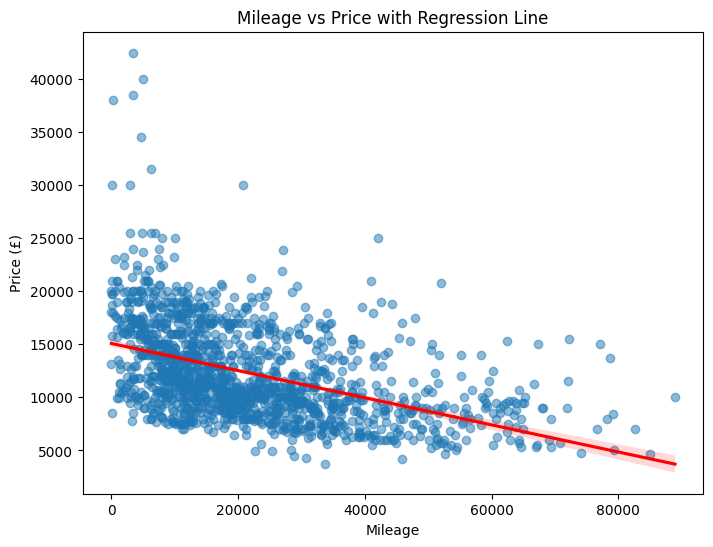

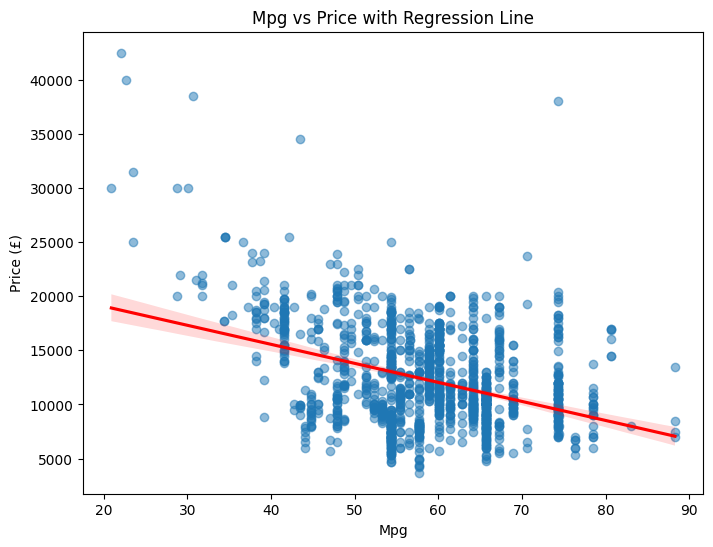

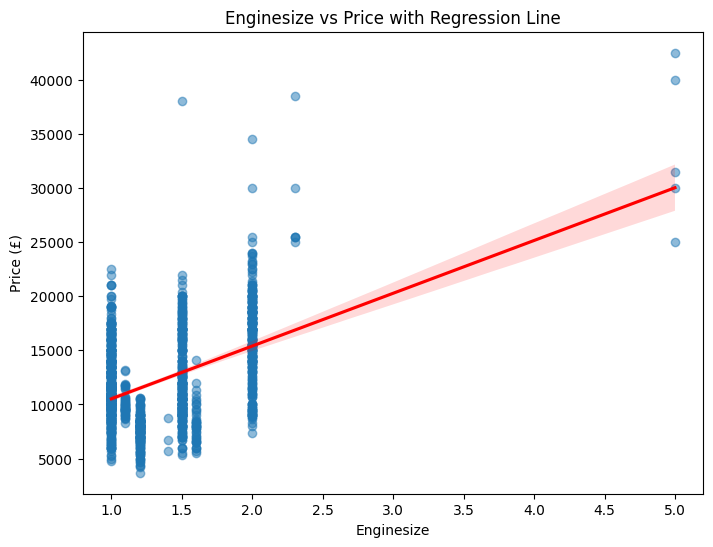

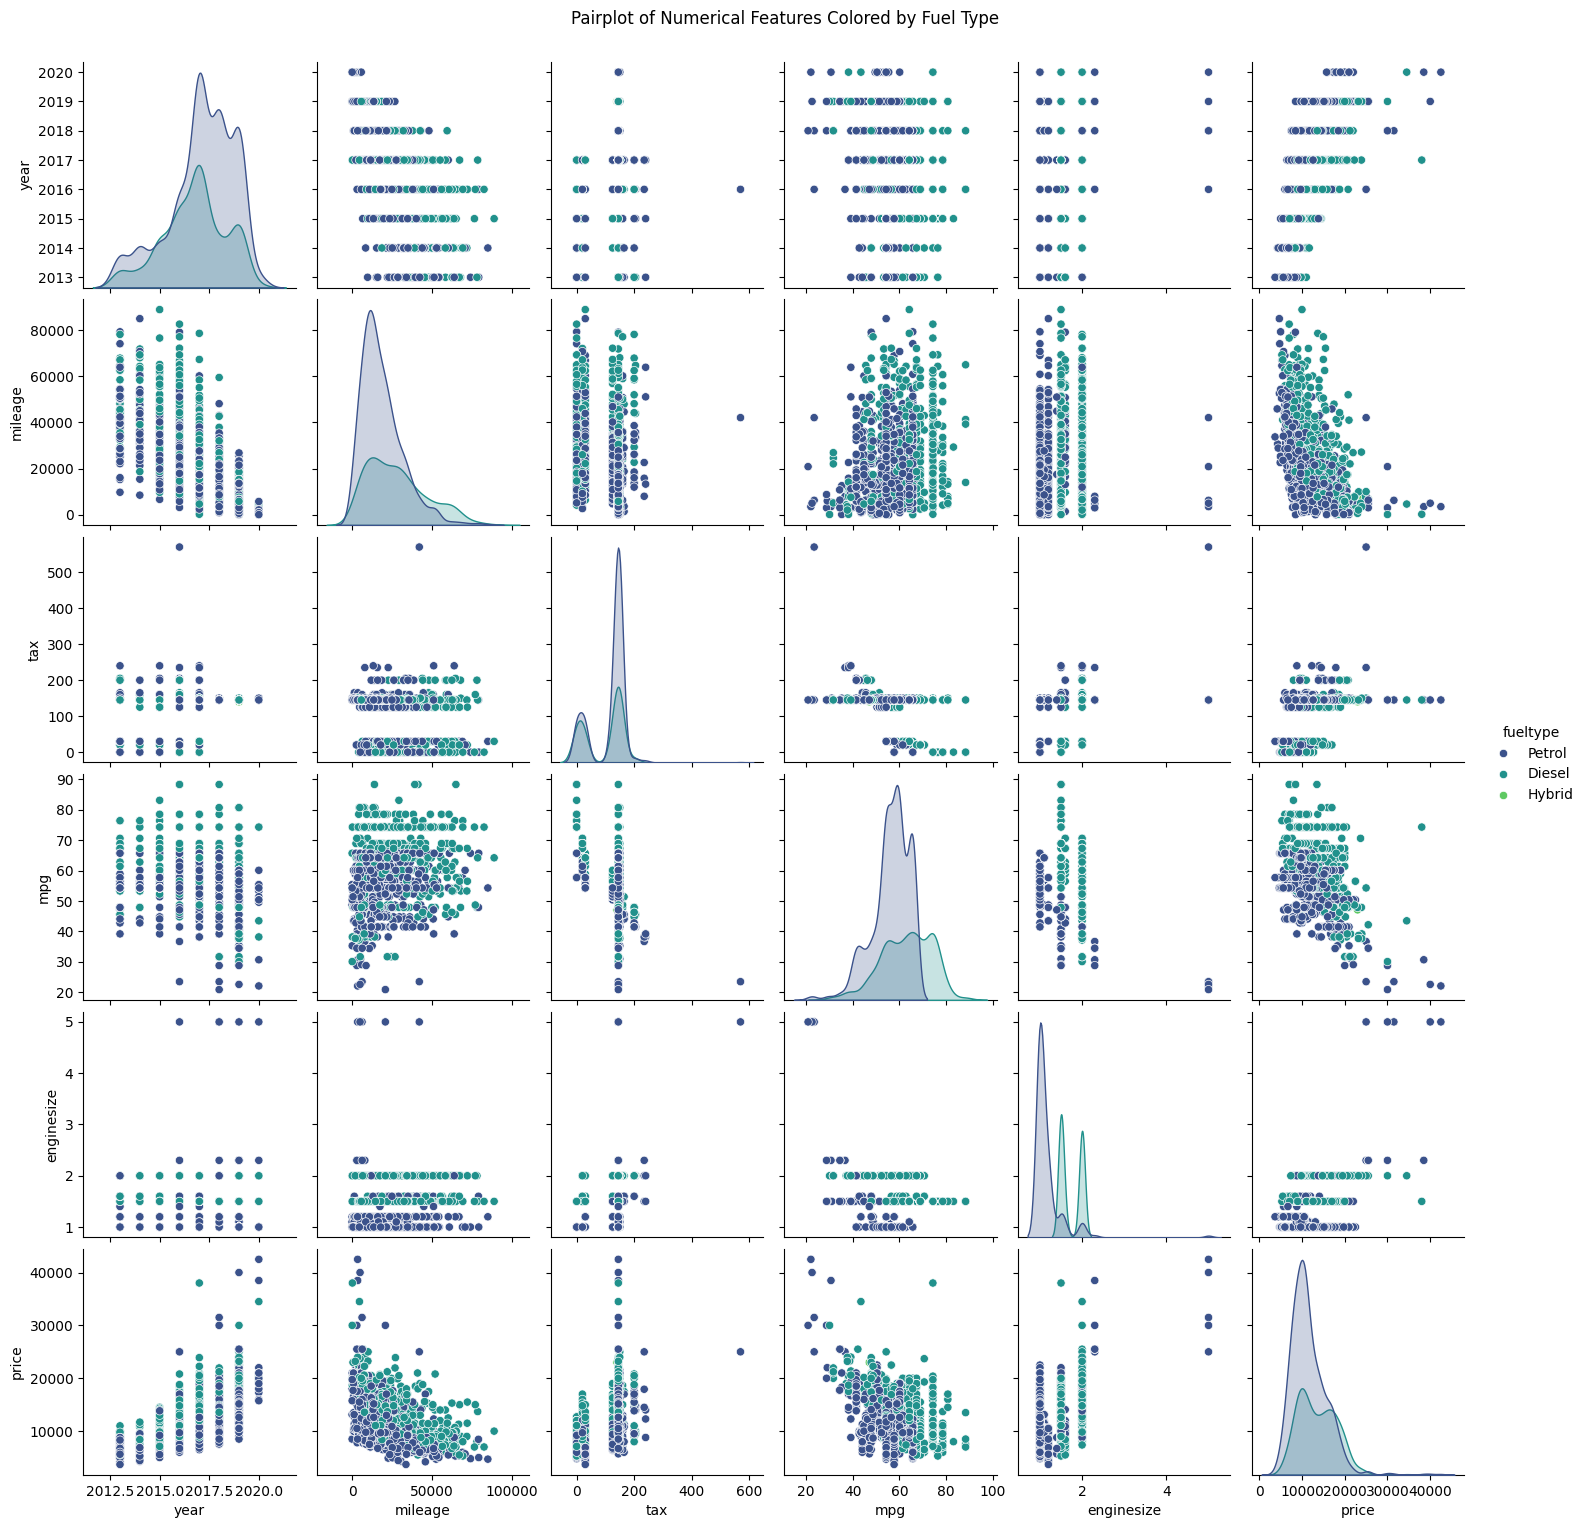

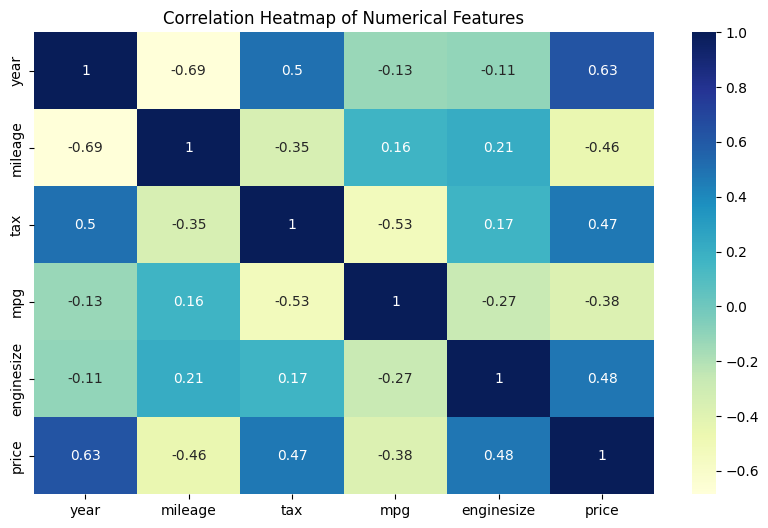

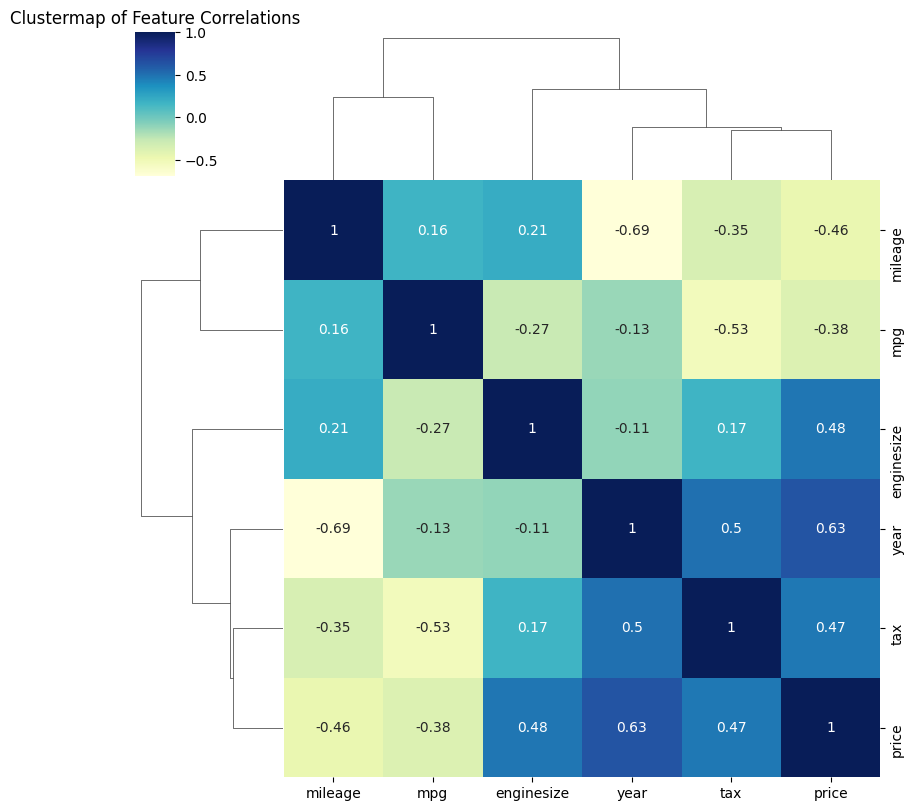

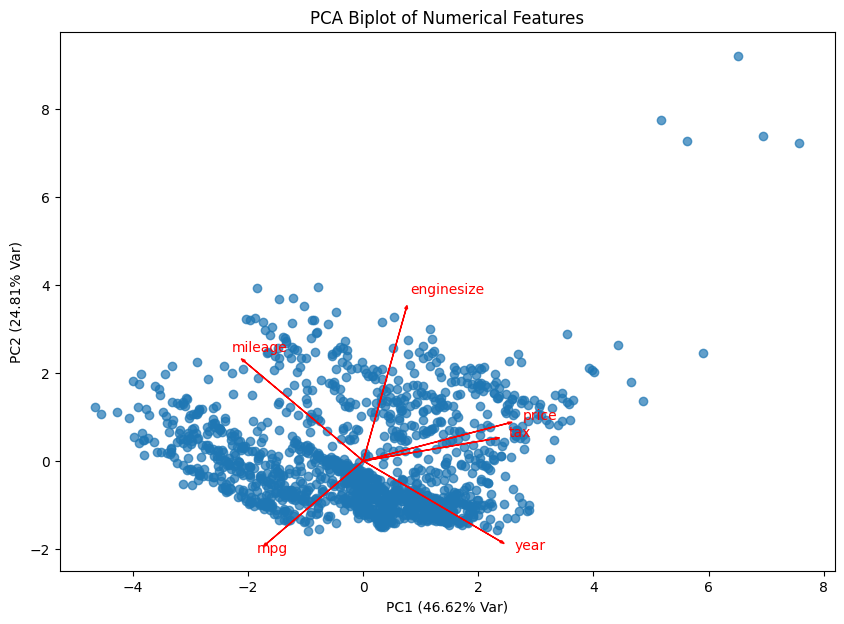

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.1.

In [39]:
# c. Categorical Variables Analysis
print("Unique Values and Counts of Categorical Variables:")
for col in categorical_cols:
    print(f"{col} - Unique Values and Counts:")
    print(data[col].value_counts())
    print()

# d. Categorical vs. Target Relationships

def plotCategoryDistribution(df, column_name, title):
    col_counts = df[column_name].value_counts().reset_index()
    col_counts.columns = [column_name, 'count']

    plt.figure(figsize=(8, 8))
    explode = [0.01] * len(col_counts)
    plt.pie(col_counts['count'], labels=col_counts[column_name], autopct='%1.1f%%', explode=explode)
    plt.title(f"{title} Distribution")
    plt.show()

def plotImpactOnPrice(df, column_name, title, target_label='price'):
    col_price = df.groupby(column_name)[target_label].mean().reset_index().sort_values(by=target_label)
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=column_name, y=target_label, data=col_price, marker='o')
    plt.title(f"Impact of '{title}' on {target_label.capitalize()}")
    plt.xlabel(title)
    plt.ylabel(f"Average {target_label.capitalize()}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Example for 'fueltype'
plotCategoryDistribution(data, 'fueltype', 'Fuel Type')
plotImpactOnPrice(data, 'fueltype', 'Fuel Type')

# Example for 'transmission'
plotCategoryDistribution(data, 'transmission', 'Transmission')
plotImpactOnPrice(data, 'transmission', 'Transmission')

# Example for 'model'
plotCategoryDistribution(data, 'model', 'Model')
plotImpactOnPrice(data, 'model', 'Model')

# e. Boxplots for Numerical Variables
for col in numerical_cols:
    plt.figure(figsize=(4,6))
    sns.boxplot(y=col, data=data, color='lightgreen')
    plt.title(f"Boxplot of {col.capitalize()}")
    plt.ylabel(col.capitalize())
    plt.show()

# f. Distribution Plots for Numerical Variables
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], kde=True)
    plt.title(f"Distribution of {col.capitalize()}")
    plt.xlabel(col.capitalize())
    plt.ylabel("Frequency")
    plt.show()

# g. Scatterplots with Regression Lines
for col in ['mileage', 'mpg', 'enginesize']:
    plt.figure(figsize=(8,6))
    sns.regplot(x=col, y='price', data=data, scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
    plt.title(f"{col.capitalize()} vs Price with Regression Line")
    plt.xlabel(col.capitalize())
    plt.ylabel("Price (£)")
    plt.show()

# h. Pairplot
sns.pairplot(data, vars=['year', 'mileage', 'tax', 'mpg', 'enginesize', 'price'], hue='fueltype', palette='viridis')
plt.suptitle("Pairplot of Numerical Features Colored by Fuel Type", y=1.02)
plt.show()

# i. Correlation Heatmap
all_numeric = numerical_cols + [target_label]
corr = data[all_numeric].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# j. Clustermap
sns.clustermap(corr, annot=True, cmap='YlGnBu', figsize=(8,8))
plt.title("Clustermap of Feature Correlations")
plt.show()

# k. PCA Biplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
X_scaled = StandardScaler().fit_transform(data[['year','mileage','tax','mpg','enginesize','price']])

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Biplot
plt.figure(figsize=(10,7))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.7)
plt.title("PCA Biplot of Numerical Features")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Var)")

# Plot feature vectors
loadings = pca.components_.T
for i, feat in enumerate(['year','mileage','tax','mpg','enginesize','price']):
    plt.arrow(0, 0, loadings[i,0]*5, loadings[i,1]*5, color='r', head_width=0.05)
    plt.text(loadings[i,0]*5*1.1, loadings[i,1]*5*1.1, feat, color='r')

plt.show()

# l. UMAP Scatter Plot (if compatible)
# Ensure compatibility by installing correct versions
# !pip install umap-learn==0.5.3  # Specify a compatible version

import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,0], X_umap[:,1], c=data['fueltype'].astype('category').cat.codes, cmap='viridis', alpha=0.7)
plt.title("UMAP Projection of Numerical Features")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.colorbar(label='Fuel Type')
plt.show()

# m. Cramér's V Heatmap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    contingency = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency)[0]
    n = contingency.values.sum()
    phi2 = chi2 / n
    r, k = contingency.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Select categorical features
cat_features = ['model', 'transmission', 'fueltype']

# Initialize the Cramér's V matrix
matrix = pd.DataFrame(index=cat_features, columns=cat_features, data=0.0)

# Compute Cramér's V for each pair of categorical features
for f1 in cat_features:
    for f2 in cat_features:
        if f1 == f2:
            matrix.loc[f1, f2] = 1.0
        else:
            matrix.loc[f1, f2] = cramers_v(data[f1], data[f2])

# Plot the heatmap
plt.figure(figsize=(6,5))
sns.heatmap(matrix.astype(float), annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér's V Heatmap for Categorical Variables")
plt.show()

# n. Cross-Tabulation Heatmap
cross_tab = pd.crosstab(data['model'], data['fueltype'])

plt.figure(figsize=(12,8))
sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='d')
plt.title("Cross-Tabulation of Model and Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Car Model")
plt.show()

# o. Parallel Coordinates Plot
from pandas.plotting import parallel_coordinates

parallel_df = data[['price','year','mileage','tax','mpg','enginesize','fueltype']].dropna()

plt.figure(figsize=(10,6))
parallel_coordinates(parallel_df, 'fueltype', colormap='viridis', alpha=0.5)
plt.title("Parallel Coordinates Plot of Features by Fuel Type")
plt.show()

# p. Andrews Curves
from pandas.plotting import andrews_curves

andrews_df = data[['price','year','mileage','tax','mpg','enginesize','fueltype']].dropna()
plt.figure(figsize=(10,6))
andrews_curves(andrews_df, 'fueltype', colormap='Set2', alpha=0.5)
plt.title("Andrews Curves by Fuel Type")
plt.show()

# q. Feature Importance from XGBoost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import joblib

# Define features and target
X = data[categorical_cols + numerical_cols]
y = data['price'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Create and train the model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

model_pipeline.fit(X_train, y_train)

# Get feature importances
regressor = model_pipeline.named_steps['regressor']
feature_names_num = numerical_cols
feature_names_cat = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = list(feature_names_num) + list(feature_names_cat)

importances = regressor.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12,8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')
plt.title("Top 15 Feature Importances from XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# r. Binning and Segmentation: Mileage
data['mileage_bin'] = pd.cut(data['mileage'], bins=5, labels=False)
avg_price_bins = data.groupby('mileage_bin')['price'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.lineplot(x='mileage_bin', y='price', data=avg_price_bins, marker='o')
plt.title("Average Price by Mileage Bins")
plt.xlabel("Mileage Bins (0=Lowest, 4=Highest)")
plt.ylabel("Average Price (£)")
plt.show()

# s. Hexbin Plot
plt.figure(figsize=(8,6))
plt.hexbin(x=data['mileage'], y=data['price'], gridsize=30, cmap='Blues', edgecolors='none')
plt.colorbar(label='Count')
plt.xlabel("Mileage")
plt.ylabel("Price (£)")
plt.title("Hexbin Density Plot of Mileage vs Price")
plt.show()

# t. KDE Comparison of Price Distributions by Fuel Type
plt.figure(figsize=(8,6))
for ftype in data['fueltype'].unique():
    subset = data[data['fueltype'] == ftype]
    sns.kdeplot(subset['price'], label=ftype, shade=True)
plt.title("KDE Comparison of Price Distributions by Fuel Type")
plt.xlabel("Price (£)")
plt.ylabel("Density")
plt.legend()
plt.show()